# Metropolis-Hastings MCMC

Author: https://www.github.com/deburky

The Metropolis-Hastings algorithm is a Markov chain Monte Carlo (MCMC) simulation method for sampling from a probability distribution. It is a generalization of the Metropolis algorithm, which is a special case of the Metropolis-Hastings algorithm.

In this example, we use the original symmetric Metropolis algorithm by sampling proposals from a normal distribution centered at the current parameter. This symmetry means the proposal probabilities cancel in the acceptance ratio.

We use $r$ as the ratio of the posterior probability of the proposed parameter to the posterior probability of the current parameter:

$$
r = \frac{p(\theta')}{p(\theta)}
$$

If $r > 1$, we accept the proposal.

If $r < 1$, we accept the proposal with probability $r$.

## Note on the prior

In the following function, we use a Gaussian prior with mean=0 and sd=1:

```python
# Define log-posterior
def log_posterior(beta, X, y):
    log_prior = -0.5 * np.sum(beta**2)  # Gaussian prior with mean=0, sd=1
    log_likelihood = np.sum(y * X.dot(beta) - np.log(1 + np.exp(X.dot(beta))))
    return log_prior + log_likelihood
```

The Gaussian prior is [defined](https://en.wikipedia.org/wiki/Gaussian_function) as follows:

$$
g(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left( -\frac{1}{2} \cdot \frac{(x - \mu)^2}{\sigma^2} \right)
$$

The $\mu$ is equal to 0, and the $\sigma$ is equal to 1 and the constant, $\frac{1}{\sqrt{2\pi}}$, gets dropped as we compare a ratio of two densities, so we have:

$$
g(x) = \exp\left( -\frac{1}{2} \cdot \frac{x^2}{1^2} \right)
$$

So in log-form, we get:

$$
g(x) = -\frac{1}{2} \cdot {x^2}
$$

In [19]:
import numpy as np
from rich.console import Console
from rich.table import Table

console = Console()

np.random.seed(123)

# Simulate data
n = 10_000
X = np.random.randn(n, 2)  # Two predictors
X = np.column_stack((np.ones(n), X))  # Add intercept
true_beta = np.array([-1, 0.5, 1])  # True coefficients
p = 1 / (1 + np.exp(-np.dot(X, true_beta)))
y = np.random.binomial(1, p)


# Define log-posterior
def log_posterior(beta, X, y):
    log_prior = -0.5 * np.sum(beta**2)  # Gaussian prior with mean=0, sd=1
    log_likelihood = np.sum(y * X.dot(beta) - np.log(1 + np.exp(X.dot(beta))))
    return log_prior + log_likelihood


sigma = 0.05  # Proposal standard deviation

# Original symmetric Metropolis algorithm
n_draws = 5_000
beta_samples = np.zeros((n_draws, X.shape[1]))
beta_current = np.zeros(X.shape[1])  # Initialize at 0
for i in range(n_draws):
    beta_proposal = beta_current + np.random.normal(
        0, sigma, size=X.shape[1]
    )  # Proposal
    log_r = log_posterior(beta_proposal, X, y) - log_posterior(beta_current, X, y)
    if np.log(np.random.rand()) < log_r:  # Accept/reject proposal
        beta_current = beta_proposal
    beta_samples[i] = beta_current

# Calculate acceptance rate
n_accepts = np.sum(np.any(np.diff(beta_samples, axis=0) != 0, axis=1))
acceptance_rate = n_accepts / (n_draws - 1)
print(f"Acceptance rate: {acceptance_rate:.3f}")

# Create a rich table with results
table = Table(title="Metropolis-Hastings")
table.add_column("Variable", justify="right")
table.add_column("\u03b8\u0302", justify="right")
table.add_column("94% HDI", justify="right")
table.add_column("Lower Bound", justify="right")
table.add_column("Upper Bound", justify="right")
for i in range(X.shape[1]):
    mean = np.mean(beta_samples[:, i])
    hdi = np.percentile(beta_samples[:, i], [2.5, 97.5])
    table.add_row(
        f"beta_{i}",
        f"{mean:.4f}",
        f"[{hdi[0]:.4f}, {hdi[1]:.4f}]",
        f"{hdi[0]:.4f}",
        f"{hdi[1]:.4f}",
    )
console.print(table)

Acceptance rate: 0.201


                          Metropolis-Hastings                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Variable ┃       θ̂ ┃            94% HDI ┃ Lower Bound ┃ Upper Bound ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│   beta_0 │ -0.9953 │ [-1.0502, -0.9401] │     -1.0502 │     -0.9401 │
│   beta_1 │  0.4882 │   [0.4352, 0.5402] │      0.4352 │      0.5402 │
│   beta_2 │  1.0204 │   [0.9617, 1.0840] │      0.9617 │      1.0840 │
└──────────┴─────────┴────────────────────┴─────────────┴─────────────┘

Below we compare the results of the Metropolis-Hastings sampler with the results of the MLE Logistic Regression.


In [2]:
from statsmodels.api import Logit

model_sm = Logit(y, X)
result = model_sm.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.517541
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sun, 13 Jul 2025   Pseudo R-squ.:                  0.1663
Time:                        20:38:16   Log-Likelihood:                -5175.4
converged:                       True   LL-Null:                       -6207.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0067      0.026    -38.968      0.000      -1.057      -0.956
x1             0.4897      0.

## Trace plots with posterior density

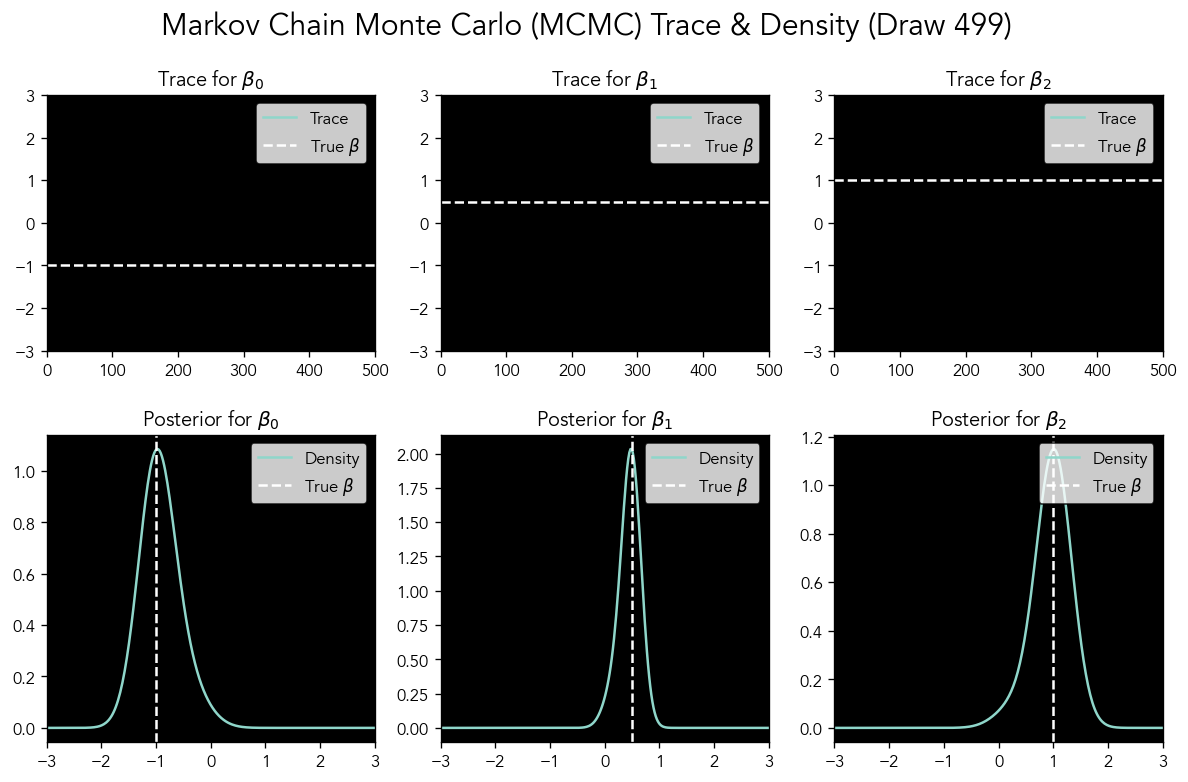

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import gaussian_kde


# Log-posterior function
def log_posterior(beta, X, y):
    log_prior = -0.5 * np.sum(beta**2)
    log_likelihood = np.sum(y * X.dot(beta) - np.log(1 + np.exp(X.dot(beta))))
    return log_prior + log_likelihood


# Proposal function (symmetric only)
def symmetric_proposal(beta, sigma=0.05):
    return beta + np.random.normal(0, sigma, size=beta.shape)


# Metropolis-Hastings sampler
def metropolis_hastings(X, y, n_draws=500, proposal_func=symmetric_proposal):
    beta_current = np.zeros(X.shape[1])
    samples = []
    for _ in range(n_draws):
        beta_proposal = proposal_func(beta_current)
        log_r = log_posterior(beta_proposal, X, y) - log_posterior(beta_current, X, y)
        if np.log(np.random.rand()) < log_r:
            beta_current = beta_proposal
        samples.append(beta_current.copy())
    return np.array(samples)


# Generate samples
samples_symmetric = metropolis_hastings(X, y, n_draws=500)

# Set up figure and animation with increased row spacing
fig, axes = plt.subplots(
    2,
    3,
    figsize=(12, 7),
    gridspec_kw={"height_ratios": [1, 1.2]},  # Extra vertical space for bottom row
)
fig.subplots_adjust(hspace=0.3)
trace_lines = [
    axes[0][j].plot([], [], lw=1.5, color="#8fd6ca", label="Trace")[0] for j in range(3)
]
true_lines = [
    axes[0][j].axhline(true_beta[j], color="white", ls="--", label="True $\\beta$")
    for j in range(3)
]

# Styling each subplot (dark inner background)
for row in axes:
    for ax in row:
        ax.set_facecolor("black")
        ax.tick_params(colors="black")
        ax.xaxis.label.set_color("black")
        ax.yaxis.label.set_color("black")
        for spine in ax.spines.values():
            spine.set_color("black")


def init():
    for line in trace_lines:
        line.set_data([], [])
    return trace_lines


def update(frame):
    for j in range(3):
        x = np.arange(frame)
        y_vals = samples_symmetric[:frame, j]

        # Update trace plot
        trace_lines[j].set_data(x, y_vals)
        axes[0][j].set_xlim(0, 500)
        axes[0][j].set_ylim(-3, 3)
        axes[0][j].set_title(f"Trace for $\\beta_{j}$")
        axes[0][j].legend(
            fontsize=10, facecolor="white", edgecolor="black", loc="upper right"
        )

        # Update KDE density plot
        axes[1][j].cla()
        if frame > 5:
            kde = gaussian_kde(y_vals, bw_method=1.5)
            grid = np.linspace(-3, 3, 300)
            axes[1][j].plot(
                grid,
                kde(grid),
                color="#8fd6ca",
                lw=1.5,
                label="Density",
            )
        axes[1][j].axvline(
            true_beta[j], color="white", linestyle="--", label="True $\\beta$"
        )
        axes[1][j].set_xlim(-3, 3)
        axes[1][j].set_title(f"Posterior for $\\beta_{j}$")
        axes[1][j].legend(
            fontsize=10, facecolor="white", edgecolor="black", loc="upper right"
        )

    fig.suptitle(
        f"Markov Chain Monte Carlo (MCMC) Trace & Density (Draw {frame})", fontsize=18
    )
    return trace_lines


ani = FuncAnimation(fig, update, frames=500, init_func=init, blit=False, interval=50)

# Save animation
ani.save("metropolis_hastings_trace_kde.gif", writer=PillowWriter(fps=20), dpi=500)

## MCMC trajectories

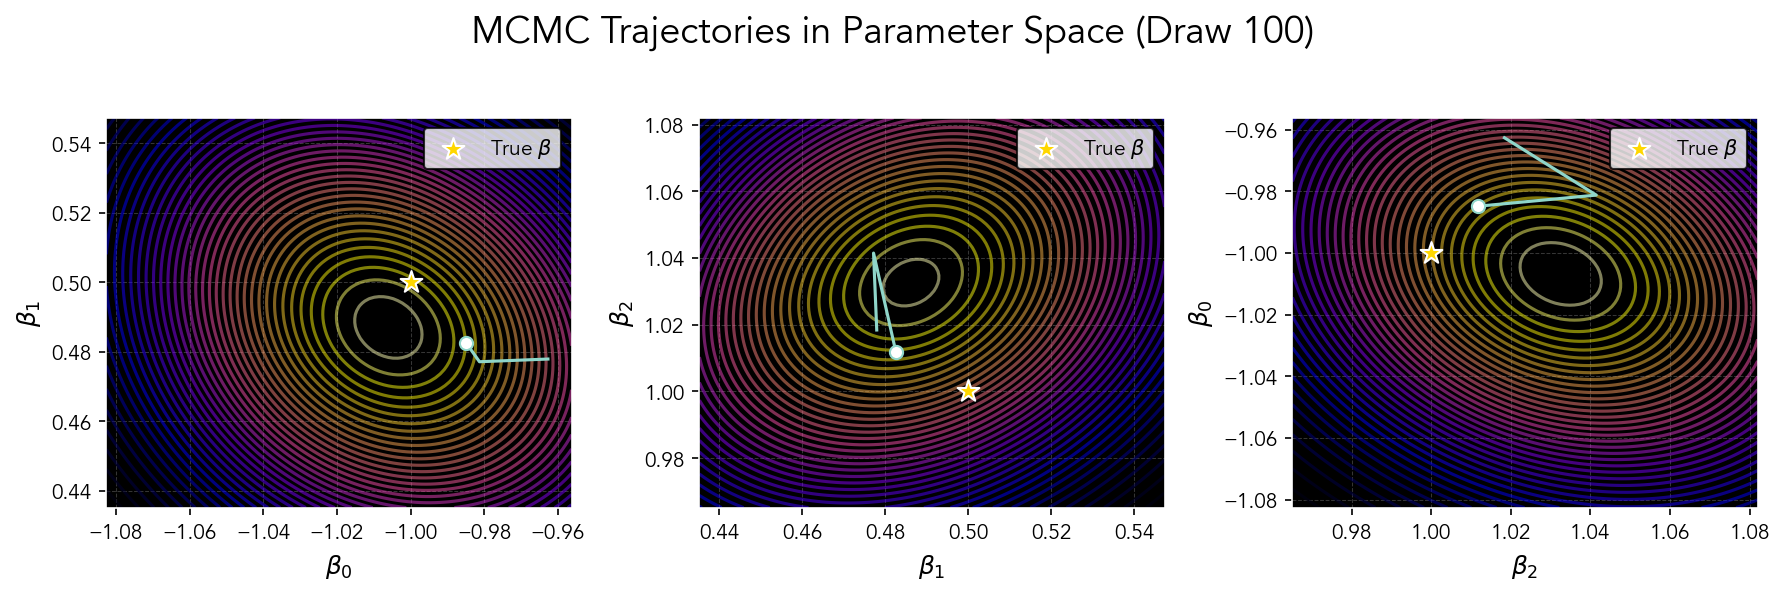

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

# Styling
plt.rcParams["font.sans-serif"] = "Avenir"
plt.rcParams["figure.dpi"] = 120

# Parameters
N_LAST_DRAWS = 500
burn_in = 100
window_size = 10
grid_size = 100

# Extract draws
beta_samples_mcmc = beta_samples[-N_LAST_DRAWS:]
posterior_samples = beta_samples_mcmc[burn_in:]
n_draws = beta_samples_mcmc.shape[0]

# Parameter index pairs and labels
pairs = [(0, 1), (1, 2), (2, 0)]
labels = [
    ("$\\beta_0$", "$\\beta_1$"),
    ("$\\beta_1$", "$\\beta_2$"),
    ("$\\beta_2$", "$\\beta_0$"),
]

# Setup figure and axes
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)


# Pre-compute KDE backgrounds
for ax, (i, j) in zip(axes, pairs, strict=False):
    x = posterior_samples[:, i]
    y = posterior_samples[:, j]
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=2.0)
    xi = np.linspace(x.min(), x.max(), grid_size)
    yi = np.linspace(y.min(), y.max(), grid_size)
    Xgrid, Ygrid = np.meshgrid(xi, yi)
    Z = np.reshape(kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).T, Xgrid.shape)
    ax.contour(Xgrid, Ygrid, Z, levels=50, cmap="gnuplot2", alpha=0.5)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis="both", which="minor", labelsize=10)
    ax.tick_params(axis="both", which="major", labelsize=10)

# Initialize trajectory lines
lines = []
for ax in axes:
    (line,) = ax.plot([], [], lw=1.5)
    lines.append(line)

# Plot true beta markers
for ax, (i, j) in zip(axes, pairs, strict=False):
    ax.scatter(
        true_beta[i],
        true_beta[j],
        color="gold",
        s=120,
        marker="*",
        edgecolor="white",
        label="True $\\beta$",
        zorder=5,
    )

# Axis labels, styling, and legend
for ax, (xlabel, ylabel) in zip(axes, labels, strict=False):
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Set dark background and white foreground after labels are assigned
    ax.set_facecolor("black")  # dark inner plot
    ax.tick_params(colors="black")  # white ticks
    ax.xaxis.label.set_color("black")  # white x-axis label
    ax.yaxis.label.set_color("black")  # white y-axis label
    for spine in ax.spines.values():
        spine.set_color("white")  # white spines

    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
    ax.legend(loc="upper right", fontsize=10, facecolor="white", edgecolor="black")

# Initialize trailing dots
dots = []
for ax in axes:
    dot = ax.scatter([], [], s=40, color="white", edgecolor="#8fd6ca", lw=1, zorder=6)
    dots.append(dot)


# Animation update function
def update(frame):
    current = burn_in + frame
    fig.suptitle(
        f"MCMC Trajectories in Parameter Space (Draw {current})",
        fontsize=18,
        weight="bold",
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    for k, _ in enumerate(axes):
        i, j = pairs[k]
        start = max(0, current - window_size)
        x = beta_samples_mcmc[start : current + 1, i]
        y = beta_samples_mcmc[start : current + 1, j]

        lines[k].set_data(x, y)
        lines[k].set_color("#8fd6ca")
        dots[k].set_offsets([[x[-1], y[-1]]])

    return lines + dots


# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=n_draws - burn_in,
    blit=False,
    interval=50,
)

# Save
ani.save("mcmc_trajectories.gif", writer=PillowWriter(fps=10), dpi=100)